## 20. 질의응답 Question Answering, QA
* 페이스북의 Babi QA 셋을 메모리 네트워크를 통해 품
* BERT를 이용하여 MRC(기계 독해 이해력) 테스트인 스쿼드(SQuAD, Stanford Question Answering Dataset) 풀어보기

### 1) 메모리 네트워크 Memory Network, MemN을 이용한 QA
#### 1. Babi 데이터셋
* 스토리, 질문, 답으로 이루어짐
* 질문이 나왔어도 스토리는 계속 이어지고 질문도 이어짐  

#### 2. 메모리 네트워크 구조
* 두 개의 입력: 스토리 문장과 질문 문장
* 각각의 임베딩 과정을 거쳐야 함  
* 이후 내적(dot product)를 통해 각 단어 간 유사도를 구하고, 소프트맥스 함수를 지나서 Embedding A로 임베딩 된 스토리 문장에 더해짐  

* 표현 바꿔서) 스토리 문장: Value와 Key, 질문 문장: Query 
* Query는 Key와 유사도를 구하고, 소프트맥스 함수를 통해 값을 정규화하여 Value에 더해서 이 유사도값을 반영해줌
* 결국 지금까지의 연산 과정은 **어텐션 메커니즘**의 의도를 가지고 있음  


* (1) 어텐션 메커니즘을 통해서 질문 문장과의 유사도를 반영한 **스토리 문장 표현**을 얻기 위한 여정
* (2) 이를 질문 문장을 임베딩한 **질문 표현**과 연결(concatenate)
* (3) 이 표현을 LSTM과 밀집층(dense layer)의 입력으로 사용하여 정답 예측

#### 3. Babi 데이터셋 전처리하기

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [2]:
# 케라스의 get_file을 통해 데이터셋을 다운로드
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
                'babi_tasks_1-20_v1-2.tar.gz')

In [3]:
# 압축을 풀고 훈련 데이터와 테스트 데이터를 각각 얻음
with tarfile.open(path) as tar:
  tar.extractall()
  tar.close()

DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [4]:
# 훈련 데이터로부터 상위 20개의 라인 읽고 출력
i = 0
lines = open(TRAIN_FILE, "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
      break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


* 숫자 1부터 15까지 한 개의 스토리
* 중간 중간에 질문이 나오고 있음
* 질문 옆에는 질문에 해당하는 정답이 적혀 있고, 정답 옆의 번호는 해당 정답이 몇 번의 라인에 있엇는지 알려줌

In [5]:
# 전처리를 거쳐 스토리, 질문, 답변을 전부 별도로 저장
def read_data(dir):
  stories, questions, answers = [], [], []
  story_temp = [] #현재 시점의 스토리 임시 저장
  lines = open(dir, "rb")

  for line in lines:
    line = line.decode("utf-8") # b' 제거
    line = line.strip() #'\n' 제거
    idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
    # 여기까지는 모든 줄에 적용되는 전처리

    if int(idx) == 1:
      story_temp = []

    if "\t" in text: #현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
      question, answer, _ = text.split("\t") #질문과 답변을 각각 저장
      stories.append([x for x in story_temp if x]) #지금까지의 누적 스토리를 스토리에 저장
      questions.append(question)
      answers.append(answer)
    
    else: #현재 읽는 줄이 스토리인 경우
      story_temp.append(text)
  
  lines.close()
  return stories, questions, answers


In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [7]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [8]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [9]:
train_stories[3576]

['John went back to the garden.',
 'Mary went to the kitchen.',
 'Sandra went back to the bedroom.',
 'John travelled to the bedroom.']

In [10]:
train_questions[3576]

'Where is John? '

In [11]:
train_answers[3576]

'bedroom'

In [12]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

In [13]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [14]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [15]:
print(word2idx)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'Sandra': 5, 'John': 6, 'Daniel': 7, 'Mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'Where': 19, 'is': 20, '?': 21}


In [16]:
vocab_size = len(word2idx) + 1

In [17]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


In [18]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [19]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [20]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


#### 4. 메모리 네트워크로 QA 테스크 풀기

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [22]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [23]:
# 플레이스 홀더. 입력을 담는 변수
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [24]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, 
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))

# 결과: (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, 
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과: (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [25]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, 
                               output_dim=embed_size, 
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과: (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [26]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [27]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이


Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [28]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)


Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


In [29]:

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)


Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [30]:
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [31]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

# start training the model
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

# save model
model.save('model.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 50)     1100        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 50)        1100        input_2[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [32]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 3ms/step - loss: 0.5234 - acc: 0.8740

 테스트 정확도: 0.8740


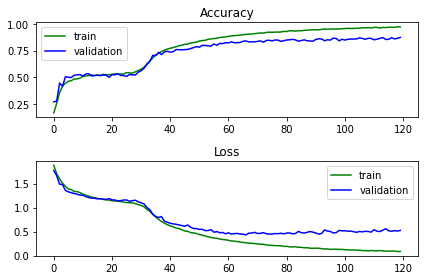

In [33]:
# Plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

### 2) MemN으로 한국어 QA
* 한국어 Babi 데이터셋에 대해서 이전 챕터에서 구현한 메모리 네트워크 
테스트

#### 1. 커스터마이즈드 KoNLPy 사용하기


In [34]:
# 사용자 사전 추가가 매우 쉬운 패키지
!pip install customized_konlpy

     |████████████████████████████████| 881 kB 5.0 MB/s 
     |████████████████████████████████| 448 kB 56.5 MB/s 
     |████████████████████████████████| 19.4 MB 6.1 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [36]:
from ckonlpy.tag import Twitter

twitter = Twitter()
twitter.morphs('은경이는 사무실로 갔습니다.')

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은', '경이', '는', '사무실', '로', '갔습니다', '.']

In [37]:
twitter.add_dictionary('은경이', 'Noun')

In [38]:
twitter.morphs('은경이는 사무실로 갔습니다.')

['은경이', '는', '사무실', '로', '갔습니다', '.']

#### 2. 한국어 Babi 데이터셋 로드와 전처리

In [39]:
from ckonlpy.tag import Twitter
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [40]:
from google.colab import files 
uploaded = files.upload()

Saving qa1_single-supporting-fact_test_kor.txt to qa1_single-supporting-fact_test_kor.txt
Saving qa1_single-supporting-fact_train_kor.txt to qa1_single-supporting-fact_train_kor.txt


In [48]:
TRAIN_FILE = os.path.join("/content/qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join("/content/qa1_single-supporting-fact_test_kor.txt")

In [49]:
# 훈련 데이터로부터 상위 20개의 문장 출력
i = 0
lines = open(TRAIN_FILE,  "rb")
for line in lines:
  line = line.decode("utf-8").strip()
  i = i + 1
  print(line)
  if i == 20:
    break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [50]:
# 전처리를 거쳐 스토리, 질문, 답변을 전부 별도로 저장
def read_data(dir):
  stories, questions, answers = [], [], []
  story_temp = [] #현재 시점의 스토리 임시 저장
  lines = open(dir, "rb")

  for line in lines:
    line = line.decode("utf-8") # b' 제거
    line = line.strip() #'\n' 제거
    idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
    # 여기까지는 모든 줄에 적용되는 전처리

    if int(idx) == 1:
      story_temp = []

    if "\t" in text: #현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
      question, answer, _ = text.split("\t") #질문과 답변을 각각 저장
      stories.append([x for x in story_temp if x]) #지금까지의 누적 스토리를 스토리에 저장
      questions.append(question)
      answers.append(answer)
    
    else: #현재 읽는 줄이 스토리인 경우
      story_temp.append(text)
  
  lines.close()
  return stories, questions, answers


In [51]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [52]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [53]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [54]:
train_stories[3572]

['은경이는 부엌으로 가버렸습니다.',
 '필웅이는 사무실로 가버렸습니다.',
 '수종이는 복도로 뛰어갔습니다.',
 '은경이는 사무실로 복귀했습니다.',
 '경임이는 사무실로 이동했습니다.',
 '경임이는 침실로 갔습니다.']

In [55]:
train_questions[3572]

'은경이는 어디야? '

In [56]:
train_answers[3572]

'사무실'

In [75]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

In [76]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [77]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [78]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [81]:
# 형태소 분석기를 사용해서 이름이 분리되지 않도록 함
twitter = Twitter()

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [82]:
print(twitter.morphs('은경이는 화장실로 이동했습니다.'))
print(twitter.morphs('경임이는 정원으로 가버렸습니다.'))
print(twitter.morphs('수종이는 복도로 뛰어갔습니다.'))
print(twitter.morphs('필웅이는 부엌으로 복귀했습니다.'))
print(twitter.morphs('수종이는 사무실로 갔습니다.'))
print(twitter.morphs('은경이는 침실로 갔습니다.'))

['은', '경이', '는', '화장실', '로', '이동', '했습니다', '.']
['경', '임', '이', '는', '정원', '으로', '가버렸습니다', '.']
['수종', '이', '는', '복도', '로', '뛰어갔습니다', '.']
['필웅이', '는', '부엌', '으로', '복귀', '했습니다', '.']
['수종', '이', '는', '사무실', '로', '갔습니다', '.']
['은', '경이', '는', '침실', '로', '갔습니다', '.']


In [83]:
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')

In [84]:
print(twitter.morphs('은경이는 화장실로 이동했습니다.'))
print(twitter.morphs('경임이는 정원으로 가버렸습니다.'))
print(twitter.morphs('수종이는 복도로 뛰어갔습니다.'))
print(twitter.morphs('필웅이는 부엌으로 복귀했습니다.'))
print(twitter.morphs('수종이는 사무실로 갔습니다.'))
print(twitter.morphs('은경이는 침실로 갔습니다.'))

['은경이', '는', '화장실', '로', '이동', '했습니다', '.']
['경임이', '는', '정원', '으로', '가버렸습니다', '.']
['수종이', '는', '복도', '로', '뛰어갔습니다', '.']
['필웅이', '는', '부엌', '으로', '복귀', '했습니다', '.']
['수종이', '는', '사무실', '로', '갔습니다', '.']
['은경이', '는', '침실', '로', '갔습니다', '.']


In [ ]:
# 이를 새로운 토큰화 함수로 정의

In [85]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

In [86]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [87]:
# 형태소 분석기를 토큰화 함수를 번경하였기 때문에 이전보다 시간이 더 소요됨
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [90]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [91]:
# 단어 집합의 크기 정의
vocab_size = len(word2idx) + 1
print(vocab_size)

25


In [92]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 40
질문의 최대 길이 : 3


In [93]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [94]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [95]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 40) (10000, 3) (10000, 25) (1000, 40) (1000, 3) (1000, 25)


#### 3. 메모리 네트워크로 QA 테스크 풀기

In [96]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [97]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [98]:
# 플레이스 홀더. 입력을 담는 변수
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [99]:
  # 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [100]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [101]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 40, 50), dtype=tf.float32, name=None), name='sequential_3/dropout_4/Identity:0', description="created by layer 'sequential_3'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 40, 3), dtype=tf.float32, name=None), name='sequential_4/dropout_5/Identity:0', description="created by layer 'sequential_4'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 3, 50), dtype=tf.float32, name=None), name='sequential_5/dropout_6/Identity:0', description="created by layer 'sequential_5'")


In [102]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이


Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 40, 3), dtype=tf.float32, name=None), name='activation_2/Softmax:0', description="created by layer 'activation_2'")


In [103]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)


Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 40), dtype=tf.float32, name=None), name='permute_1/transpose:0', description="created by layer 'permute_1'")


In [104]:

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)


Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 90), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [105]:
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [106]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

# start training the model
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

# save model
model.save('model.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, None, 50)     1250        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 3, 50)        1250        input_4[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [107]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 1.8590e-04 - acc: 1.0000

 테스트 정확도: 1.0000


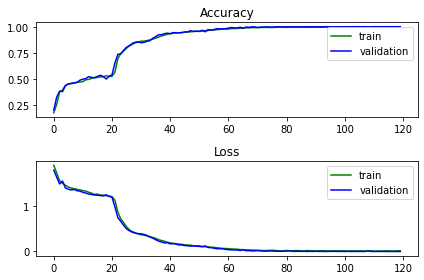

In [108]:
# Plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [109]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이는 어디야 ?          : 복도      복도
필웅이는 어디야 ?          : 화장실     화장실
경임이는 어디야 ?          : 부엌      부엌
경임이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 부엌      부엌
경임이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 정원      정원
수종이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 사무실     사무실
수종이는 어디야 ?          : 사무실     사무실
필웅이는 어디야 ?          : 부엌      부엌
필웅이는 어디야 ?          : 정원      정원
수종이는 어디야 ?          : 사무실     사무실
필웅이는 어디야 ?          : 침실      침실
필웅이는 어디야 ?          : 침실      침실
은경이는 어디야 ?          : 부엌      부엌
은경이는 어디야 ?          : 정원      정원
은경이는 어디야 ?          : 부엌      부엌
수종이는 어디야 ?          : 사무실     사무실
은경이는 어디야 ?          : 부엌      부엌
필웅이는 어디야 ?          : 복도      복도
은경이는 어디야 ?          : 사무실     사무실
은경이는 어디야 ?          : 사무실     사무실
경임이는 어디야 ?          : 복도      복도
수종이는 어디야 ?          : 침실      침실
경임이는 어디야 ?          : 침실      침실
필웅이는 어디야 ?          : 침실      침실
수종이는 어디야 ?          : 부엌      부엌
